## Recency feature investigation

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [37]:
import os
import re
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
import sqlite3
from tqdm import tqdm
import random
import pickle
from datetime import datetime
import bisect

import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib
import pylab as pl
from IPython.core.display import display, HTML

import networkx as nx
import scipy, scipy.stats

In [2]:
train_filepath = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/author_initiations/author_initiation_choices_train_all.csv"
test_filepath = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/author_initiations/author_initiation_choices_test_all.csv"

In [5]:
train = pd.read_csv(train_filepath)

In [6]:
test = pd.read_csv(test_filepath)

In [7]:
len(train), len(test)

(3878525, 690025)

In [8]:
train.head()

,choice_id,initiator_user_id,candidate_user_id,is_target,target_outdegree,target_indegree,target_has_indegree,is_reciprocal,is_weakly_connected,is_friend_of_friend,...,initiator_author_type,target_health_condition,is_health_condition_shared,target_is_multisite_author,target_is_mixedsite_author,target_update_count,target_update_frequency,target_days_since_most_recent_update,target_days_since_first_update,target_site_visits
0,0,15878504,5758186,1,10,41,1,0,1,0,...,cg,Cancer,1,0,0,628,10.271729,0.000000,1118.324664,118271
1,0,15878504,8745849,0,0,1,1,0,1,0,...,cg,Cardiovascular/Stroke,0,0,0,17,2.249373,1132.466331,226.729861,1962
2,0,15878504,7054610,0,3,3,1,0,1,0,...,cg,Neurological Condition,0,0,0,11,5.774769,1446.314942,57.145139,440
3,0,15878504,24619441,0,0,0,0,0,0,0,...,cg,Other,0,0,0,5,40.986717,322.235081,3.659722,161
4,0,15878504,12664705,0,0,0,0,0,0,0,...,cg,Cancer,1,0,0,17,1.863397,504.827442,273.693750,2765


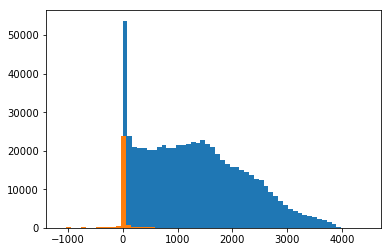

In [12]:
plt.hist(test[test.is_target == 0].target_days_since_most_recent_update, bins=50)
plt.hist(test[test.is_target == 1].target_days_since_most_recent_update, bins=50)
plt.show()

In [42]:
correct_count = 0
total = 0
for key, group in test.groupby(by='choice_id'):
    true_days_since_most_recent_update = group.target_days_since_most_recent_update.iloc[0]
    total += 1
    if np.min(group.target_days_since_most_recent_update) == true_days_since_most_recent_update:
        correct_count += 1
correct_count, total, correct_count / total

(22371, 27601, 0.8105141118075432)

In [43]:
correct_count = 0
total = 0
for key, group in test.groupby(by='choice_id'):
    true_days_since_most_recent_update = group.target_days_since_most_recent_update.iloc[0]
    if true_days_since_most_recent_update <= 0:
        continue
    total += 1
    if np.min(group.target_days_since_most_recent_update) == true_days_since_most_recent_update:
        correct_count += 1
correct_count, total, correct_count / total

(18723, 23953, 0.7816557424957208)

In [23]:
correct_count, total, correct_count / total

(18723, 23953, 0.7816557424957208)

In [15]:
# a small percent of these values are < 0... why?
np.sum(train.target_days_since_most_recent_update < 0) / len(train)

0.003004234857323338

In [16]:
np.sum(test.target_days_since_most_recent_update < 0) / len(test)

0.0026868591717691386

In [20]:
np.sum(np.isclose(train.target_days_since_most_recent_update, 0)) / len(train),\
np.sum(train.target_days_since_most_recent_update > 0) / len(train)

(0.00281472982641597, 0.9941810353162607)

In [21]:
4000 / 365

10.95890410958904

## Pan et al. 2017 correlation between in-degree and out-degree

Quick and dirty analysis.

In [24]:
# read the user->user interactions dataframe
metadata_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/user_metadata"
u2u_df = pd.read_feather(os.path.join(metadata_dir,"u2u_df.feather"))
len(u2u_df)

14812407

In [25]:
# load the list of valid users
data_selection_working_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/data_selection"
valid_user_ids = set()
with open(os.path.join(data_selection_working_dir, "valid_user_ids.txt"), 'r') as infile:
    for line in infile:
        user_id = line.strip()
        if user_id == "":
            continue
        else:
            valid_user_ids.add(int(user_id))
len(valid_user_ids)

362345

In [26]:
# load the list of valid sites
data_selection_working_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/data_selection"
valid_site_ids = set()
with open(os.path.join(data_selection_working_dir, "valid_site_ids.txt"), 'r') as infile:
    for line in infile:
        site_id = line.strip()
        if site_id == "":
            continue
        else:
            valid_site_ids.add(int(site_id))
len(valid_site_ids)

340414

In [27]:
valid_u2u_df = u2u_df[(u2u_df.from_user_id.isin(valid_user_ids))&(u2u_df.to_user_id.isin(valid_user_ids))]
len(valid_u2u_df), len(valid_u2u_df) / len(u2u_df)

(10441676, 0.704927700136784)

In [28]:
outdegrees = valid_u2u_df.groupby(by='from_user_id').count()

In [29]:
indegrees = valid_u2u_df.groupby(by='to_user_id').count()

In [31]:
degrees = pd.merge(outdegrees.reset_index(), indegrees.reset_index(), left_on='from_user_id', right_on='to_user_id', validate='one_to_one')

In [33]:
degrees['indegree'] = degrees.created_at_y
degrees['outdegree'] = degrees.created_at_x

In [39]:
# this isn't actually indegree and outdegree, this is "in-replies" vs "out-replies"
# this correlation is a bit lower than that found in Pan et al. 2017
scipy.stats.pearsonr(degrees.indegree, degrees.outdegree)

(0.4050065375072285, 0.0)

In [40]:
inits_df = valid_u2u_df.sort_values(by='created_at', ascending=True).drop_duplicates(subset=['from_user_id', 'to_user_id'], keep='first')
outdegrees = inits_df.groupby(by='from_user_id').count()
indegrees = inits_df.groupby(by='to_user_id').count()
degrees = pd.merge(outdegrees.reset_index(), indegrees.reset_index(), left_on='from_user_id', right_on='to_user_id', validate='one_to_one')
degrees['indegree'] = degrees.created_at_y
degrees['outdegree'] = degrees.created_at_x

In [41]:
scipy.stats.pearsonr(degrees.indegree, degrees.outdegree)

(0.46808401534183214, 0.0)